In [1]:
import numpy as np
import networkx as nx

In [12]:
class Polynomial:
    def __init__(self, coeffs: list[int]):
        """
        Makes a polynomial with integer coefficients

        Args:
            coeffs: a list of integers representing the coefficients to the polynomial.
            For example f(x) = 2x + x^2 would be represented by [0, 2, 1].
        """
        self.coeffs = coeffs
        self.deriv = self.diff()

    def diff(self):
        return [self.coeffs[i] * i for i in range(1, len(self.coeffs))]

    def __call__(self, x: int, deriv: bool = False):
        """
        Evaluate the polynomial at input x

        if deriv is true, then evaluate the derivative of the polynomial
        """
        coeffs = self.coeffs if not deriv else self.deriv

        res = 0
        for i, c in enumerate(coeffs):
            res += round(c * x**i)
        
        return res

In [13]:
def get_inverse(x: int, p: int):
    """
    Get the inverse of x mod p
    """
    for i in range(p):
        if (x * i) % p == 1:
            return i

    raise ValueError(f"No inverses found for x = {x}, p = {p}")

In [22]:
def lift(poly: Polynomial, p: int, max_j: int = 5):
    """
    lift will create a graph of solutions to f mod successive powers of a prime

    Args:
        poly: Polynomial you want to use
        p: the prime you want to take the lifts of
    """
    g = nx.Graph()
    # go through each value between [0, p-1] and add them as nodes in the graph
    # if they are a solution to f(x) = 0
    for x in range(p):
        if poly(x) == 0:
            g.add_node(x)

    # helper is recursive and will add nodes and edges to the above graph if the
    # conditions are satisfied
    def helper(a: int, j: int):
        if j > max_j:
            return

        deriv = poly(a, True)

        if deriv % p != 0:
            second_term = poly(a) / p**j
            inv = get_inverse(poly(a, True), p)
            t = (-inv * second_term) % p

            a_prime = round(a + t * p**j)

            g.add_node(a_prime)
            g.add_edge(a, a_prime)

            helper(a_prime, j + 1)
        else:
            # test one solution, if it works then they are all solutions
            # otherwise none are solutions
            # we will just test `a` as we can set t = 0

            if poly(a) % 9 == 0:
                for i in range(p):
                    a_prime = round(a + i * p**j)
                    g.add_node(a_prime)
                    g.add_edge(a, a_prime)

                    helper(a_prime, j + 1)

    for a in range(p):
        if poly(a) % p == 0:
            g.add_node(1)
            helper(a, 1)

    return g

In [26]:
poly = Polynomial([7, 1, 1])

g1 = lift(poly, 3)


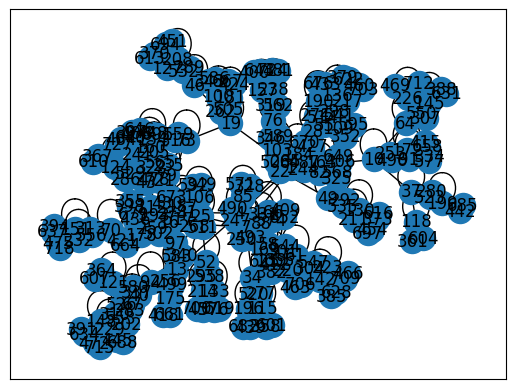

In [27]:
nx.draw_networkx(g1)

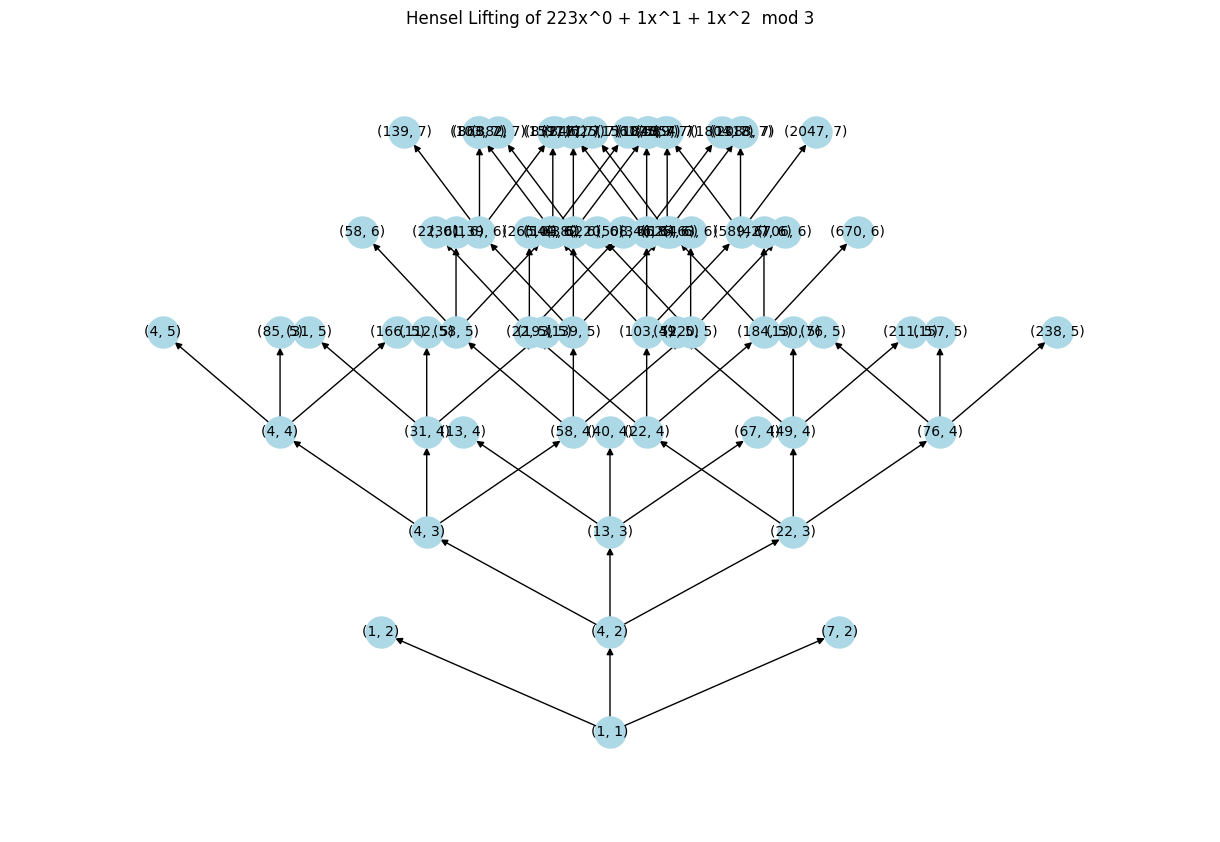

In [39]:
# /// script
# dependencies = [
#   "networkx",
#   "matplotlib"
# ]
# ///

import networkx as nx
import matplotlib.pyplot as plt


def get_inverse(x: int, p: int) -> int:
    """
    Return the modular inverse of x modulo p.
    (Assumes that p is prime and x is not divisible by p.)
    """
    for i in range(1, p):
        if (x * i) % p == 1:
            return i
    raise ValueError(f"No inverse for {x} modulo {p}")


class Polynomial:
    def __init__(self, coeffs: list[int]):
        """
        Create a polynomial with integer coefficients.
        For example, f(x) = 2x + x^2 is represented by [0, 2, 1].
        """
        self.coeffs = coeffs
        self.deriv_coeffs = self.diff()

    def diff(self) -> list[int]:
        """Return the list of coefficients for the derivative."""
        return [i * self.coeffs[i] for i in range(1, len(self.coeffs))]

    def __call__(self, x: int, deriv: bool = False) -> int:
        """
        Evaluate the polynomial (or its derivative) at x.

        Args:
            x: The input value.
            deriv: If True, evaluate the derivative.
        """
        coeffs = self.deriv_coeffs if deriv else self.coeffs
        result = 0
        for i, c in enumerate(coeffs):
            result += c * (x**i)
        return result

    def __str__(self):
        res = ""
        for i, c in enumerate(self.coeffs):
            res += f"{c}x^{i} + "
        return res[:-2]


def lift(poly: Polynomial, p: int, max_j: int = 5) -> nx.DiGraph:
    """
    Create a directed graph representing the lifting of solutions of a polynomial f modulo
    successive powers of a prime p via Hensel's lemma.

    Each node is a tuple (a, j) meaning that a is a solution modulo p^j. An edge from
    (a, j) to (b, j+1) indicates that b is a valid Hensel lift of a.

    Args:
        poly: Polynomial object representing f(x)
        p: prime number for lifting
        max_j: maximum exponent (i.e. we find solutions modulo p^(max_j))

    Returns:
        A networkx.DiGraph representing the solution tree.
    """
    G = nx.DiGraph()

    def helper(a: int, j: int):
        node = (a, j)
        # Stop if we've reached the maximum exponent.
        if j >= max_j:
            return

        next_level = j + 1
        mod_next = p**next_level  # modulus for the next level
        f_val = poly(a)
        f_deriv = poly(a, deriv=True)

        # Case 1: Unique lift when f'(a) is invertible mod p.
        if f_deriv % p != 0:
            # Since a is a solution mod p^j, write f(a) = p^j * k.
            k = f_val // (p**j)
            inv = get_inverse(f_deriv, p)
            t = (-k * inv) % p
            a_next = a + t * (p**j)
            next_node = (a_next, next_level)
            if poly(a_next) % mod_next == 0:
                G.add_edge(node, next_node)
                helper(a_next, next_level)
        else:
            # Case 2: f'(a) ≡ 0 (mod p): multiple lifts exist only if f(a) is divisible by p^(j+1)
            if poly(a) % mod_next == 0:
                for i in range(p):
                    a_next = a + i * (p**j)
                    next_node = (a_next, next_level)
                    if poly(a_next) % mod_next == 0:
                        G.add_edge(node, next_node)
                        helper(a_next, next_level)
            # If f(a) is not divisible by p^(j+1), then no lift exists.

    # Start at level 1: find solutions modulo p.
    mod_level1 = p
    for a in range(p):
        if poly(a) % mod_level1 == 0:
            node = (a, 1)
            G.add_node(node)
            helper(a, 1)

    return G


# --- Custom Tree Layout (fallback) ---
def custom_tree_layout(G: nx.DiGraph, x_spacing=3.0, y_spacing=1.5) -> dict:
    """
    A simple recursive layout for tree (or forest) graphs. Nodes are assumed to be
    tuples of the form (value, level) and will be placed so that the y-coordinate
    equals (level-1) * y_spacing (i.e. level 1 is at y=0, the bottom).
    """
    pos = {}
    # Get all roots (nodes at level 1)
    roots = [node for node in G.nodes if node[1] == 1]
    roots = sorted(roots, key=lambda n: n[0])
    n_roots = len(roots)
    # Spread roots horizontally using the given x_spacing.
    total_width = n_roots * x_spacing * 2
    for i, root in enumerate(roots):
        root_x = -total_width / 2 + (i + 0.5) * (total_width / n_roots)
        pos[root] = (root_x, (root[1] - 1) * y_spacing)
        _custom_tree_layout_rec(G, root, pos, root_x, x_spacing, y_spacing)
    return pos


def _custom_tree_layout_rec(
    G: nx.DiGraph, node, pos: dict, parent_x: float, x_spacing: float, y_spacing: float
):
    children = list(G.successors(node))
    if not children:
        return
    children = sorted(children, key=lambda n: n[0])
    k = len(children)
    # Center children around parent's x-position
    child_x_start = parent_x - (k - 1) * x_spacing / 2
    for i, child in enumerate(children):
        child_x = child_x_start + i * x_spacing
        pos[child] = (child_x, (child[1] - 1) * y_spacing)
        _custom_tree_layout_rec(G, child, pos, child_x, x_spacing * 0.8, y_spacing)


# --- Improved Plotting ---
def plot_lift_graph(
    G: nx.DiGraph,
    p: int,
    max_j: int = 5,
    title: str = None,
    use_graphviz: bool = False,
    x_scale: float = 2.0,
    x_spacing: float = 3.0,
    y_spacing: float = 1.5,
):
    """
    Plot the Hensel lifting graph using a hierarchical layout that minimizes edge crossings.
    The graph is arranged so that the roots (solutions modulo p) are at the bottom.
    You can choose to force a custom layout (which will obey x_spacing and x_scale) by setting
    use_graphviz=False.

    Args:
        G: networkx.DiGraph representing the lift tree.
        p: the prime used for lifting.
        max_j: maximum level in the graph.
        title: title for the plot.
        use_graphviz: if True, try using Graphviz's "dot" layout (parameters might not be obeyed).
                      If False, force the custom layout.
        x_scale: a multiplier to scale the x-coordinates.
        x_spacing: horizontal spacing parameter for the custom layout.
        y_spacing: vertical spacing between levels.
    """
    pos = None
    if use_graphviz:
        try:
            # Try using pygraphviz if installed
            pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
        except Exception as e1:
            try:
                # Try using pydot if installed
                pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
            except Exception as e2:
                pos = custom_tree_layout(G, x_spacing=x_spacing, y_spacing=y_spacing)
    else:
        pos = custom_tree_layout(G, x_spacing=x_spacing, y_spacing=y_spacing)

    # Override the y-coordinate so that each node's y = (level-1)*y_spacing,
    # and apply the x_scale to spread them out.
    for node in pos:
        x, _ = pos[node]
        pos[node] = (x * x_scale, (node[1] - 1) * y_spacing)

    # Optionally, adjust the plot limits to see the effect of scaling.
    xs = [x for (x, y) in pos.values()]
    ys = [y for (x, y) in pos.values()]

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        arrows=True,
        node_size=500,
        font_size=10,
    )
    plt.xlim(min(xs) - 2, max(xs) + 2)
    plt.ylim(min(ys) - 2, max(ys) + 2)
    plt.title(title or f"Hensel Lifting Graph (mod powers of {p})")
    plt.show()


# === Example Usage ===
if __name__ == "__main__":
    # For example, take f(x) = x^2 + x + 223 (represented by coefficients [223, 1, 1])
    poly = Polynomial([223, 1, 1])
    prime = 3
    max_level = 7

    # Compute the lift graph
    G = lift(poly, prime, max_level)

    # Visualize the lift tree with the improved layout.
    # Set use_graphviz=False to force the custom layout, and then adjust x_scale and x_spacing.
    plot_lift_graph(
        G,
        prime,
        max_level,
        title=f"Hensel Lifting of {poly} mod {prime}",
        use_graphviz=False,  # force custom layout for better parameter control
        x_scale=1.0,  # try an extreme x scaling factor
        x_spacing=3,  # and extreme x spacing between siblings
        y_spacing=2.0,
    )
